### Modeling Risk Factors

* Define a market environment 
    * starting value
    * volatility
    * start and end date
    * currency
    * frequency for discretization
    * Number of simulations
    
    

In [1]:
import dx
import numpy as np
np.random.seed(1000)
import pandas as pd
import datetime as dt
import seaborn as sns; sns.set()
import matplotlib as mpl; 
%matplotlib inline

In [2]:
r = dx.constant_short_rate('r', 0.01)

## instantiation of market environment object
me_1 = dx.market_environment('me', dt.datetime(2016, 1, 1))
## starting value of simulated processes
me_1.add_constant('initial_value', 100.)
## volatiltiy factor
me_1.add_constant('volatility', 0.2)
## horizon for simulation
me_1.add_constant('final_date', dt.datetime(2016, 6, 30))
## currency of instrument
me_1.add_constant('currency', 'EUR')
## frequency for discretization (here: weekly)
me_1.add_constant('frequency', 'W')
## number of paths
me_1.add_constant('paths', 25000)
## short rate model for discount curve
me_1.add_curve('discount_curve', r)

In [3]:
gbm_1 = dx.geometric_brownian_motion('gbm_1', me_1)
gbm_1

In [4]:
gbm_1.get_instrument_values()

array([[ 100.        ,  100.        ,  100.        , ...,  100.        ,
         100.        ,  100.        ],
       [ 103.99970675,  100.94138063,  101.87289049, ...,  101.57080458,
         100.82390334,   98.15531921],
       [ 101.93603717,   94.66240389,   91.81649108, ...,  101.20745936,
          99.98530091,  102.49930045],
       ..., 
       [  94.34847745,  111.87828236,  105.88943893, ...,   89.84492969,
         109.03063645,  107.8625328 ],
       [  91.01721535,  113.83465258,  102.59432299, ...,   92.09515398,
         104.17599152,  101.67756176],
       [  90.56511589,  113.20730366,  100.79160449, ...,   90.91965416,
         100.6385713 ,  101.76583508]])

In [7]:
gbm_1.time_grid

array([datetime.datetime(2016, 1, 1, 0, 0),
       datetime.datetime(2016, 1, 3, 0, 0),
       datetime.datetime(2016, 1, 10, 0, 0),
       datetime.datetime(2016, 1, 17, 0, 0),
       datetime.datetime(2016, 1, 24, 0, 0),
       datetime.datetime(2016, 1, 31, 0, 0),
       datetime.datetime(2016, 2, 7, 0, 0),
       datetime.datetime(2016, 2, 14, 0, 0),
       datetime.datetime(2016, 2, 21, 0, 0),
       datetime.datetime(2016, 2, 28, 0, 0),
       datetime.datetime(2016, 3, 6, 0, 0),
       datetime.datetime(2016, 3, 13, 0, 0),
       datetime.datetime(2016, 3, 20, 0, 0),
       datetime.datetime(2016, 3, 27, 0, 0),
       datetime.datetime(2016, 4, 3, 0, 0),
       datetime.datetime(2016, 4, 10, 0, 0),
       datetime.datetime(2016, 4, 17, 0, 0),
       datetime.datetime(2016, 4, 24, 0, 0),
       datetime.datetime(2016, 5, 1, 0, 0),
       datetime.datetime(2016, 5, 8, 0, 0),
       datetime.datetime(2016, 5, 15, 0, 0),
       datetime.datetime(2016, 5, 22, 0, 0),
       datetime.d

* Monte Carlo Simulated paths for evolution of EUR Currency

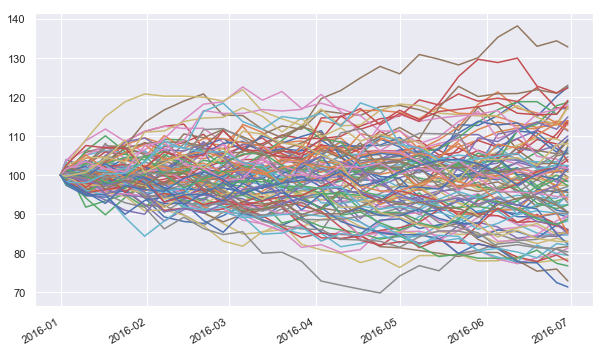

In [9]:
pdf_1 = pd.DataFrame(gbm_1.get_instrument_values(), index=gbm_1.time_grid)
pdf_1.ix[:, :100].plot(legend=False, figsize=(10, 6));

#### Add volatility to the environment

In [10]:
## instantiate new market environment object
me_2 = dx.market_environment('me_2', me_1.pricing_date)
## add complete environment
me_2.add_environment(me_1)
## overwrite volatility value
me_2.add_constant('volatility', 0.5)

In [12]:
gbm_2 = dx.geometric_brownian_motion('gbm_2', me_2)

#### Compare the original brownian motion with the increased vol version

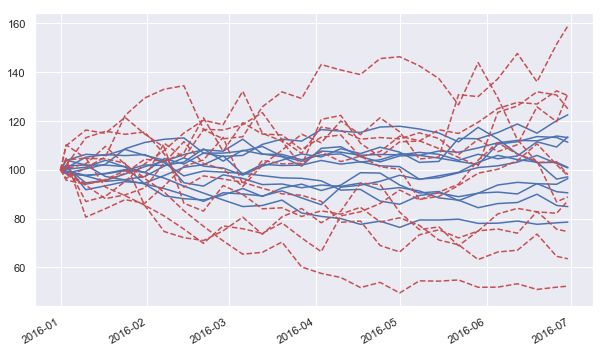

In [13]:
pdf_2 = pd.DataFrame(gbm_2.get_instrument_values(), index=gbm_2.time_grid)
ax = pdf_1.ix[:, :10].plot(legend=False, figsize=(10, 6), style=11 * ['b-']);
pdf_2.ix[:, :10].plot(legend=False, style=11 * ['r--'], ax=ax);

### Derivative Modeling

* Given risk factors we can define derivatives models
* 

* American option on the European Currency Underlying

In [26]:
## instantiation of market environment object for option
me_opt = dx.market_environment('me_opt', me_1.pricing_date)
## add complete market environment
me_opt.add_environment(me_1)
## add maturity date for option
me_opt.add_constant('maturity', dt.datetime(2016, 6, 30))
## add strike for option
me_opt.add_constant('strike', 110.)

In [15]:
am_put = dx.valuation_mcs_american_single(
            name='am_put',  # name of the option as string
            underlying=gbm_1,  # the risk factor object
            mar_env=me_opt,  # the market environment
            payoff_func='np.maximum(strike - instrument_values, 0)')

In [18]:
am_put.present_value()  # Monte Carlo estimator

11.798999999999999

In [19]:
am_put.delta()  # delta of the option

-0.68089999999999995

In [20]:
am_put.gamma()  # gamma of the option

0.0149

In [21]:
0.5 * am_put.gamma() * am_put.underlying.initial_value ** 2  # dollar gamma

74.5

In [22]:
am_put.vega()  # vega of the option

23.820799999999998

In [23]:
am_put.theta()  # theta of the option 

-3.8100000000000001

In [24]:
am_put.rho()  # rho of the option

-30.113

* European Option on the market volatility

In [28]:
eur_call = dx.valuation_mcs_european_single(
            name='eur_call',
            underlying=gbm_2,
            mar_env=me_opt,
            payoff_func='np.maximum(maturity_value - strike, 0)')

In [29]:
eur_call.present_value()

10.364663

In [30]:
eur_call.delta()

0.41739999999999999

In [32]:
eur_call.gamma()

0.0121

In [33]:
0.5 * eur_call.gamma() * eur_call.underlying.initial_value ** 2

60.5

In [34]:
eur_call.vega()

27.614699999999999

In [35]:
eur_call.theta()

-14.1996

In [37]:
eur_call.rho()

18.0684

In [38]:
k_list = np.arange(80., 120.5, 2.5)
pv = []; de = []; ve = []; th = []; rh = []; ga = []
for k in k_list:
    eur_call.update(strike=k)
    pv.append(eur_call.present_value())
    de.append(eur_call.delta())
    ve.append(eur_call.vega())
    th.append(eur_call.theta())
    rh.append(eur_call.rho())
    ga.append(eur_call.gamma())

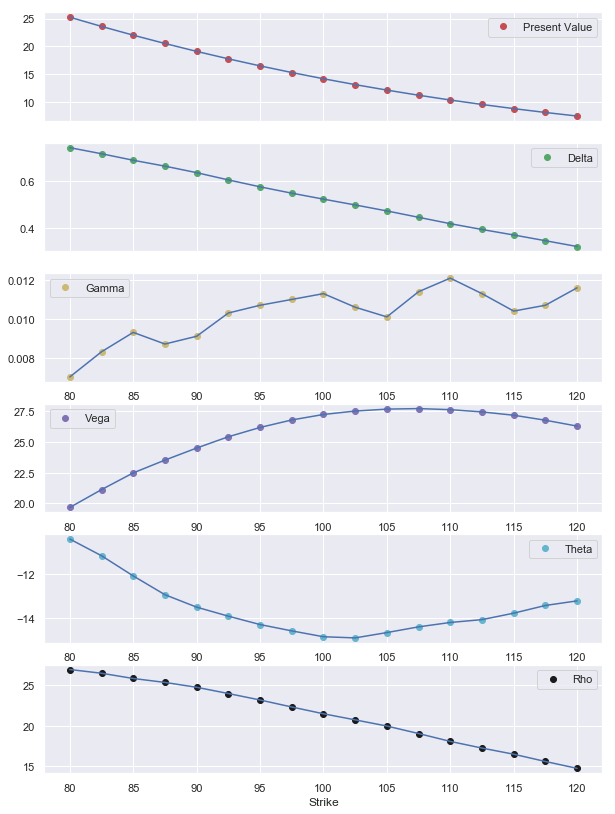

In [39]:
dx.plot_option_stats_full(k_list, pv, de, ga, ve, th, rh)

#### Derivatives Portfolios

* to compose portfolio of two options we need to define derivative positions
* 

In [41]:
me_1.add_constant('model', 'gbm')
me_2.add_constant('model', 'gbm')

In [42]:
put = dx.derivatives_position(
    name='put',  # name as string
    quantity=2,  # number of options in the portfolio
    underlyings=['gbm_1'],  # the underlying(s) as list object
    mar_env=me_opt,  # the market environment object
    otype='American single',  # the option type
    payoff_func='np.maximum(strike - instrument_values, 0)')  # the payoff

call = dx.derivatives_position(
    name='call',
    quantity=3,
    underlyings=['gbm_2'],
    mar_env=me_opt,
    otype='European single',
    payoff_func='np.maximum(maturity_value - strike, 0)')

In [43]:
risk_factors = {'gbm_1': me_1, 'gbm_2' : me_2}  # as dictionary
correlations = [['gbm_1', 'gbm_2', -0.4]]  # as list
positions = {'put' : put, 'call' : call}  # as dictionary

In [44]:
val_env = dx.market_environment('general', dt.datetime(2016, 1, 1))
val_env.add_constant('frequency', 'W')
val_env.add_constant('paths', 25000)
val_env.add_constant('starting_date', val_env.pricing_date)
val_env.add_constant('final_date', val_env.pricing_date)
val_env.add_curve('discount_curve', r)

In [45]:
port = dx.derivatives_portfolio(
        name='portfolio',  # name as string
        positions=positions,  # derivatives positions
        val_env=val_env,  # valuation environment
        risk_factors=risk_factors, # relevant risk factors
        correlations=correlations,  # correlation between risk factors
        parallel=False)  # parallel valuation True/False

* Simulation and Valuation


In [48]:
port.get_values()  # get all present values

Total
 pos_value    54.103966
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value
0,put,put,2,American single,[gbm_1],11.804000,EUR,23.608000
1,call,call,3,European single,[gbm_2],10.165322,EUR,30.495966


In [49]:
port.get_statistics()  # get major statistics

Totals
 pos_value     54.1030
pos_delta      0.0082
pos_vega     130.9992
dtype: float64


,position,name,quantity,otype,risk_facts,value,currency,pos_value,pos_delta,pos_vega
0,put,put,2,American single,[gbm_1],11.804,EUR,23.608,-1.4192,48.7344
1,call,call,3,European single,[gbm_2],10.165,EUR,30.495,1.4274,82.2648


In [50]:
deltas, benchvalue = port.get_port_risk(Greek='Delta')


gbm_2
0.8
0.9
1.0
1.1
1.2

gbm_1
0.8
0.9
1.0
1.1
1.2





In [51]:
deltas

gbm_1_Delta  gbm_2_Delta
major minor                           
0.8   factor    80.000000    80.000000
      value     90.513966    33.277564
0.9   factor    90.000000    90.000000
      value     70.893966    41.943616
1.0   factor   100.000000   100.000000
      value     54.103966    54.103966
1.1   factor   110.000000   110.000000
      value     42.185966    69.735565
1.2   factor   120.000000   120.000000
      value     35.365966    88.385101

In [52]:
benchvalue

54.103966

In [54]:
dx.risk_report(deltas)


gbm_1_Delta
major  minor 
0.8    factor     80.00
       value      90.51
0.9    factor     90.00
       value      70.89
1.0    factor    100.00
       value      54.10
1.1    factor    110.00
       value      42.19
1.2    factor    120.00
       value      35.37
Name: gbm_1_Delta, dtype: float64

gbm_2_Delta
major  minor 
0.8    factor     80.00
       value      33.28
0.9    factor     90.00
       value      41.94
1.0    factor    100.00
       value      54.10
1.1    factor    110.00
       value      69.74
1.2    factor    120.00
       value      88.39
Name: gbm_2_Delta, dtype: float64


In [58]:
vegas, benchvalue = port.get_port_risk(Greek='Vega')


gbm_2
0.8
0.9
1.0
1.1
1.2

gbm_1
0.8
0.9
1.0
1.1
1.2





In [59]:
vegas

gbm_1_Vega  gbm_2_Vega
major minor                         
0.8   factor    0.160000    0.400000
      value    52.399966   45.916783
0.9   factor    0.180000    0.450000
      value    53.197966   49.998826
1.0   factor    0.200000    0.500000
      value    54.103966   54.103966
1.1   factor    0.220000    0.550000
      value    55.049966   58.220116
1.2   factor    0.240000    0.600000
      value    56.007966   62.339230